# Speech Emotion recognition

This notebook contains two parts 
1. `Exploratory Data Analysis`
2. `Modelling`

# Exploratory Data Analysis

## Importing required packages and data

In [1]:
# Importing required packages
import pandas as pd
import numpy as np
import os
from pathlib import Path
import random 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from sklearn.preprocessing import LabelEncoder
plt.rcParams["figure.figsize"] = (10, 7)
import librosa
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset
paths = [] 
labels = []
data_path = Path("../data")
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1].split(".")[0]
        labels.append(label.lower())
        
    if len(paths) == 2800:
            break
print("Dataset loaded")

Dataset loaded


## Data Exploration

In [3]:
print("Number of samples in the dataset:", len(paths))

Number of samples in the dataset: 2800


In [4]:
# view the first 5 samples in paths
paths[:5]

['..\\data\\OAF_angry\\OAF_back_angry.wav',
 '..\\data\\OAF_angry\\OAF_bar_angry.wav',
 '..\\data\\OAF_angry\\OAF_base_angry.wav',
 '..\\data\\OAF_angry\\OAF_bath_angry.wav',
 '..\\data\\OAF_angry\\OAF_bean_angry.wav']

In [5]:
# view the first 5 samples in labels
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

#### convert the lists to DataFrame for easier access and visualization

In [6]:
data_df = pd.DataFrame()
data_df["paths"] = paths
data_df["labels"] = labels

### Data Visualization

In [7]:
data_df["labels"].value_counts()

labels
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

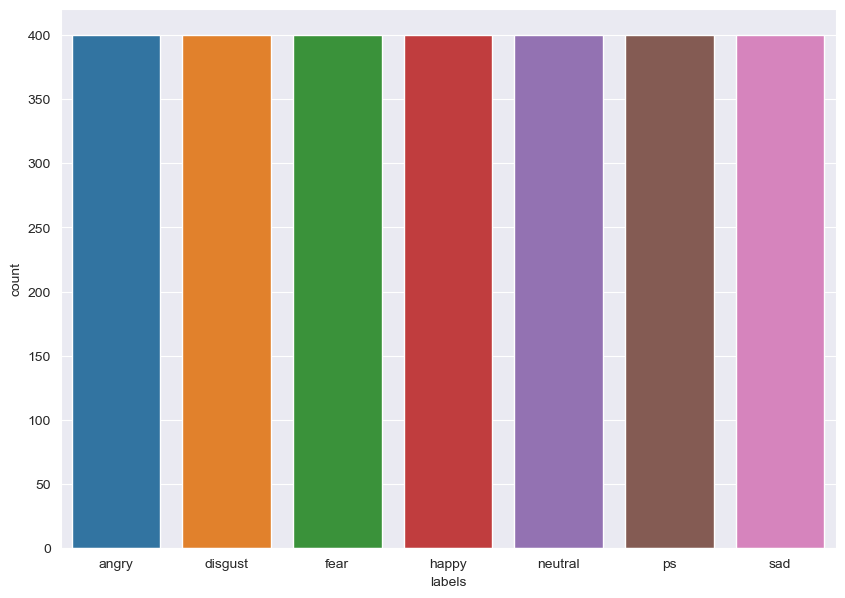

In [8]:
sns.countplot(data=data_df, x="labels")
plt.show()

We can say that our dataset is balanced this means all classes are having the same number of samples

In [9]:
def waveplot(index):
    input_data = read(paths[index])
    audio = input_data[1]
    plt.plot(audio)
    plt.title(labels[index])
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.show()

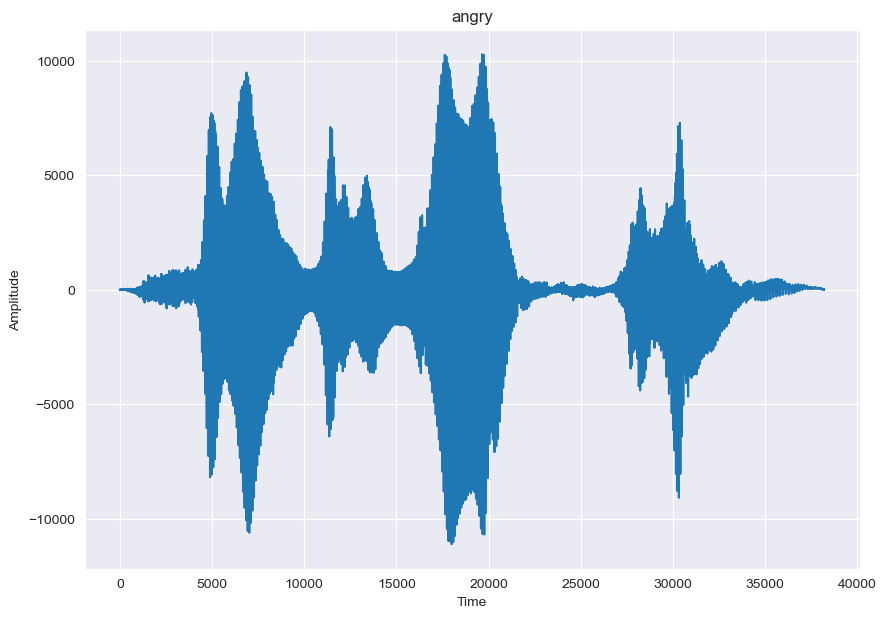

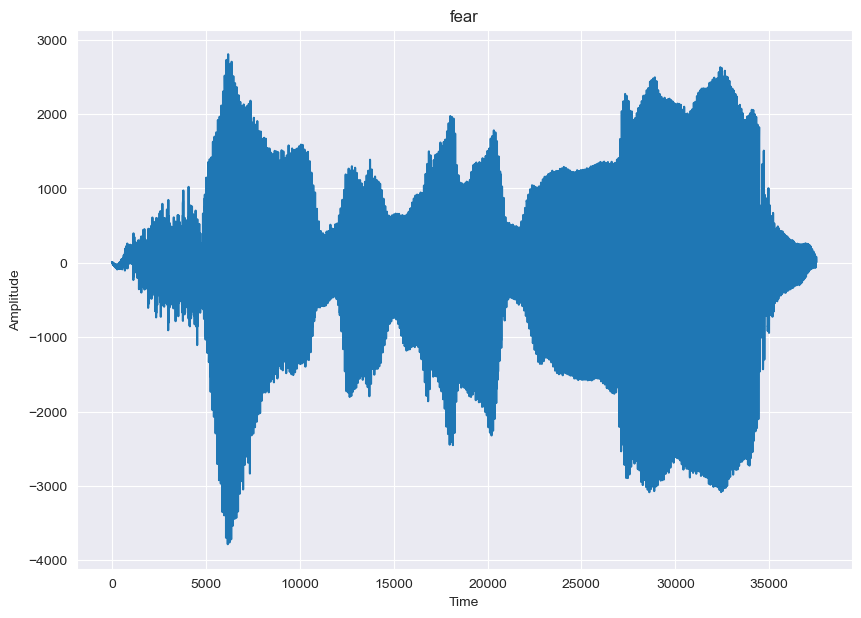

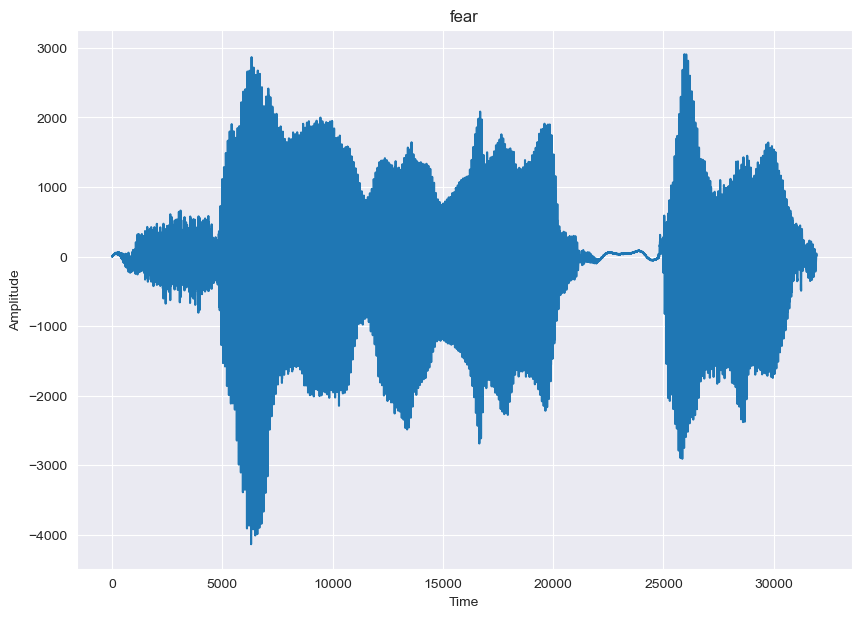

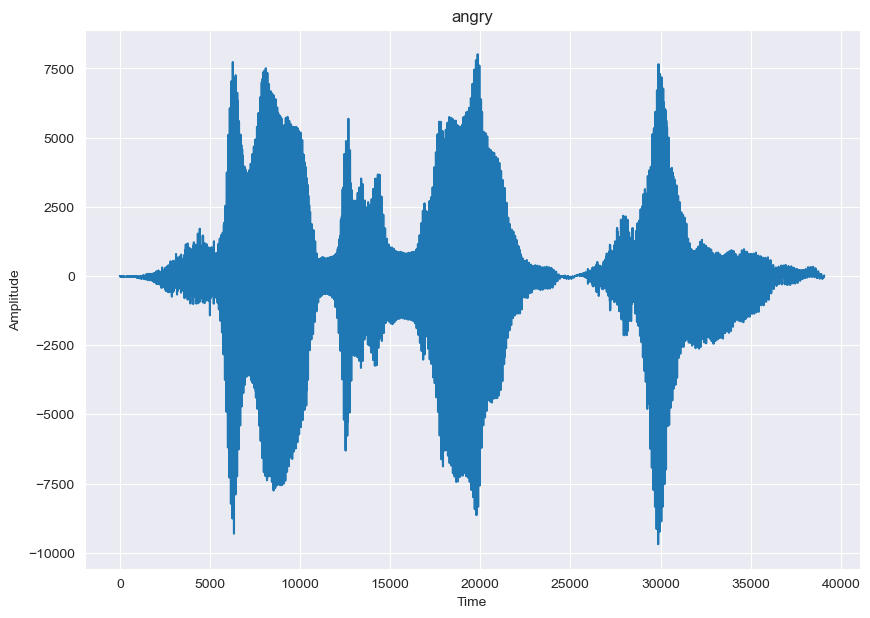

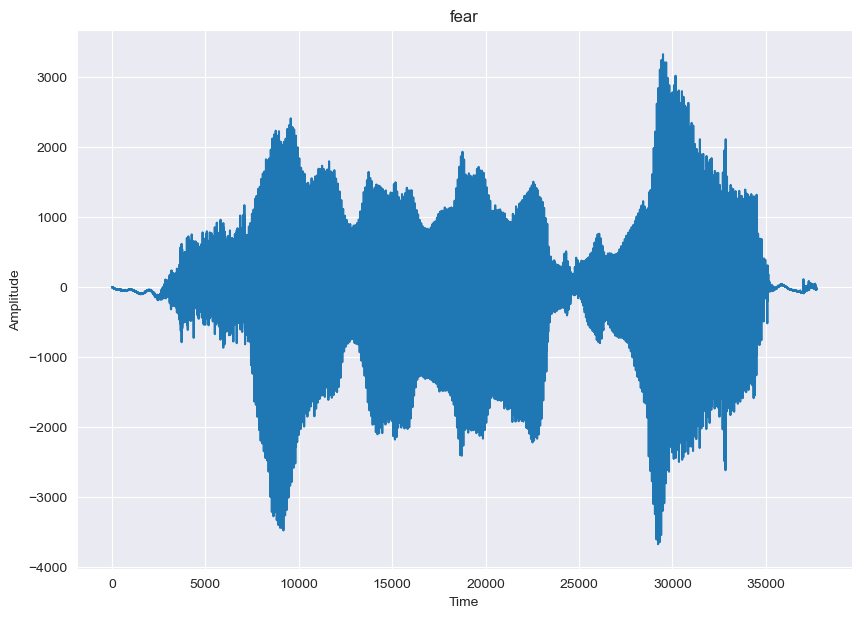

In [10]:
for i in range(5):
    randint = random.randint(0, len(paths))
    waveplot(randint)

## Feature Extraction

In [11]:
def extract_mfcc(filename):
     y, sr = librosa.load(filename, duration=3, offset=0.5)
     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
     return mfcc

In [12]:
# Testing the function
extract_mfcc(data_df["paths"][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275506e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228313e+00, -5.57365894e-01, -1.83255327e+00,  2.02101514e-01,
        7.27551103e-01,  1.31773770e+00,  2.88633752e+00,  2.85579133e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
       -7.55126143e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722402e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996375e+00, -1.82390726e+00,
        4.86896276e+00,  9.31392288e+00,  2.08915043e+00, -1.90649128e+00],
      dtype=float32)

In [13]:
X_mfcc = data_df['paths'].apply(lambda x: extract_mfcc(x))
X_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.65600896, -32.74544, ...
2       [-429.79196, 46.124, 1.5550478, -0.21709506, 2...
3       [-403.46118, 76.32369, -12.531774, -22.288858,...
4       [-434.05756, 77.4455, 10.8655, 16.092943, 8.04...
                              ...                        
2795    [-553.2201, 89.83577, 27.215466, 16.407124, 19...
2796    [-589.23676, 96.20408, 36.96118, 15.014448, 28...
2797    [-533.41815, 85.43242, 27.791998, 19.307178, 2...
2798    [-548.6142, 110.16424, 31.910236, 12.572517, 2...
2799    [-549.2962, 102.374565, 32.268833, 26.261616, ...
Name: paths, Length: 2800, dtype: object

Now our dataset is ready

# Modelling

### Splitting the data into feature and labels

In [14]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(2800, 40)

In [15]:
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

The shape represents the number of samples in the dataset and features in a single dimension array

### Encoding the labels


In [16]:
enc = LabelEncoder()
y = enc.fit_transform(data_df["labels"])
class_list = enc.classes_

In [17]:
class_list

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
      dtype=object)

## Splitting the data into training and testing set s

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(2240, 2240, 560, 560)

## Modelling 

In [19]:
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import LSTM, Dropout, LSTM, Dense

In [20]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

In [21]:
model.fit(X_train, y_train,
          batch_size=32, 
          epochs=100,
          validation_data= (X_test, y_test),
          callbacks=[keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy',
                                                   restore_best_weights=True)])

Epoch 1/100
70/70 [==============================] - 13s 150ms/step - loss: 0.8892 - accuracy: 0.6871 - val_loss: 0.3326 - val_accuracy: 0.8839
Epoch 2/100
70/70 [==============================] - 10s 145ms/step - loss: 0.2791 - accuracy: 0.9165 - val_loss: 0.1379 - val_accuracy: 0.9518
Epoch 3/100
70/70 [==============================] - 10s 144ms/step - loss: 0.1352 - accuracy: 0.9594 - val_loss: 0.2222 - val_accuracy: 0.9464
Epoch 4/100
70/70 [==============================] - 10s 141ms/step - loss: 0.1469 - accuracy: 0.9567 - val_loss: 0.1265 - val_accuracy: 0.9500
Epoch 5/100
70/70 [==============================] - 10s 146ms/step - loss: 0.1043 - accuracy: 0.9679 - val_loss: 0.0645 - val_accuracy: 0.9786
Epoch 6/100
70/70 [==============================] - 11s 154ms/step - loss: 0.1068 - accuracy: 0.9670 - val_loss: 0.0539 - val_accuracy: 0.9804
Epoch 7/100
70/70 [==============================] - 10s 150ms/step - loss: 0.1038 - accuracy: 0.9652 - val_loss: 0.1230 - val_accuracy:

Our model achieves an accuracy of 99% on test data  which is excellent